Start Gambler World 2018-08-19 10:31:32.517837
Sweep1 : delta 0.953344
Sweep2 : delta 0.368896
Sweep3 : delta 0.139264
Sweep4 : delta 0.055706


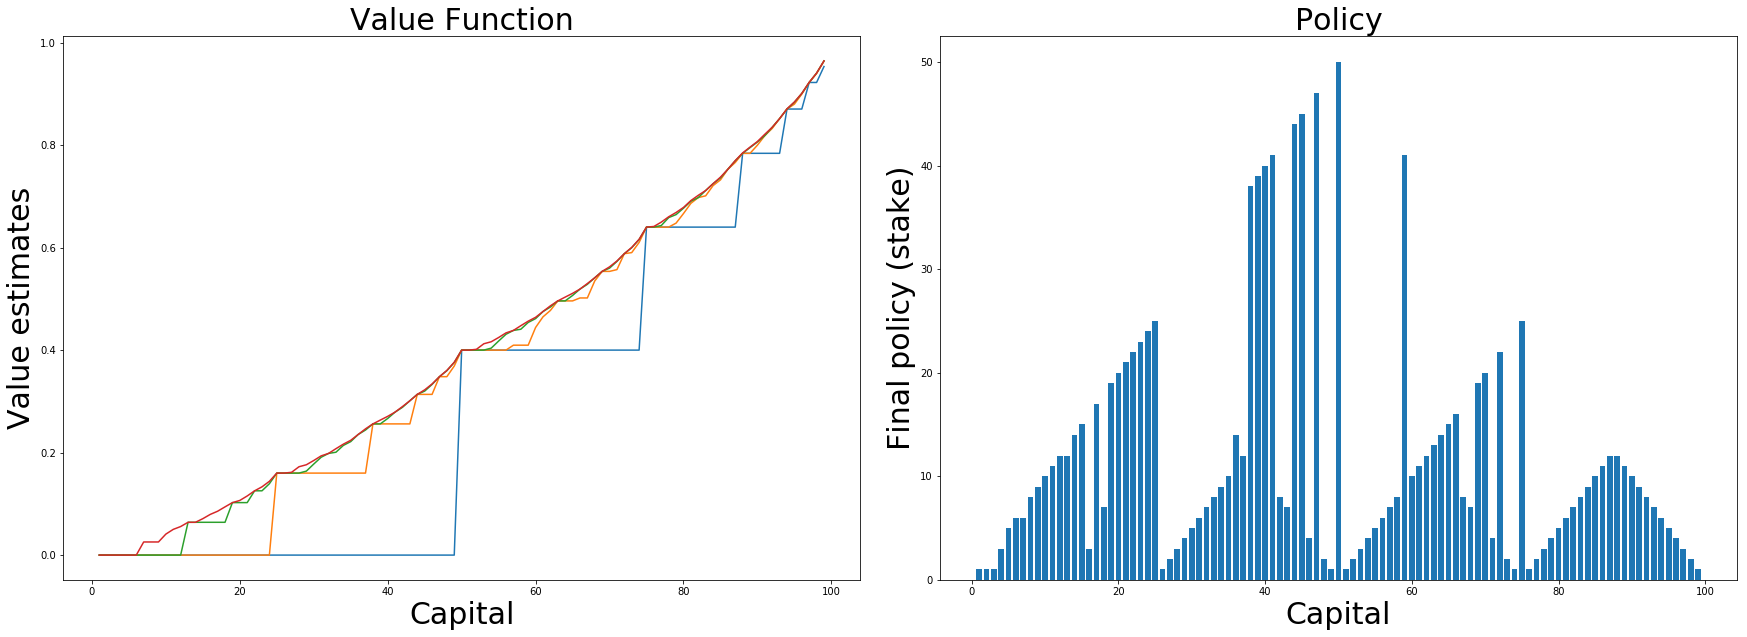

End Gambler World 2018-08-19 10:31:33.065305
Running Time 0:00:00.547468


In [2]:
""" Example 4.2 Jack's Car Rental

Author : SeongJin Yoon
"""
import numpy as np
from enum import Enum
import math
import matplotlib.pyplot as plt
import datetime as dt
MIN = 0
MAX = 1

class ConfigDict(dict):
    def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs)
    def __getattr__(self, name): return self[name]
    def __setattr__(self, name, value): self[name] = value
    def __delattr__(self, name): del self[name]
        
config = ConfigDict()
config.env = ConfigDict(max_capital = 99, goal = 100)
config.value = ConfigDict(discount = 1.0, theta = 1e-200)
config.state = ConfigDict(terminal = [0, 100])

class Plot():
    def __init__(self, nrows, ncols, figsize):
        self.fig_idx = 0
        
        _, self.axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=figsize)
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        self.axes = self.axes.flatten()

    def draw_mline_begin(self, labels):       
        ax=self.axes[self.fig_idx]
        
        ax.set_xlabel(labels[0], fontsize=30)
        ax.set_ylabel(labels[1], fontsize=30)
        ax.set_title(labels[2], fontsize=30)
        
        return ax
        
    def draw_mline(self, ax, pos, data, label):
        ax.plot(pos, data, label=label)

    def draw_mline_end(self):       
        self.fig_idx += 1

    def draw_bar(self, pos, data, labels):
        ax=self.axes[self.fig_idx]
        ax.bar(pos, data)
        
        ax.set_xlabel(labels[0], fontsize=30)
        ax.set_ylabel(labels[1], fontsize=30)
        ax.set_title(labels[2], fontsize=30)
        self.fig_idx += 1
        
    def show(self):
        plt.show()

class Reward(Enum):
    """Reward classes."""
    reach_goal = 1
    
class Environment():
    def __init__(self):
        self.prepare_environment()
        
    def prepare_environment(self):
        self.num_state = config.env.max_capital
        self.num_action = config.env.max_capital
        
        self.state_list = list(range(1, self.num_state + 1))
        self.reward_list = {Reward.reach_goal : 1}

    def get_statelist(self):
        return self.state_list
    
    def get_actionlist(self, state):
        return range(1, min(state, config.env.goal - state) + 1)

    def get_num_state(self):
        return self.num_state

    def get_num_action(self):
        return self.num_action

    def get_state(self):
        state = tuple((self.branch1.get_state(), self.branch2.get_state()))
        return state

    def get_reward(self, reward_type):
        return self.reward_list[reward_type]

    def validate(self, state, action):
        
        half_goal = config.env.goal//2
        
        if state <= half_goal and action > state:
            return False
        
        elif state > half_goal and action > (config.env.goal - state):
            return False
        
        return True

    def lookahead_do_action(self, state, action, header):
        
        if self.validate(state, action)  is False:
            return 0

        self.state = state

        if header is True:
            self.state += action
        else:
            self.state -= action
        
        if self.state == config.env.goal:
            reward = self.get_reward(Reward.reach_goal)
        else:
            reward = 0

        return self.state, reward

class Agent():
    def __init__(self, env):
        
        self.env = env
        self.state_list = env.get_statelist()
        self.num_state = env.get_num_state()
        
        self.plot = Plot(nrows=1, ncols=2, figsize=(30,10))
        self.policy_labels = ['Capital', 'Final policy (stake)', 'Policy']
        self.v_labels = ['Capital', 'Value estimates', 'Value Function']
        
    def value_iteration(self):
        # 1. Initialize
        self.value_function = np.zeros((self.num_state))
        
        # 2. prepare plot
        ax = self.plot.draw_mline_begin(self.v_labels)       
       
        theta = config.value.theta
        sweep_count = 1

        while True:
            delta = 0
            for state in self.state_list:
                state_idx = state - 1
                v = self.value_function[state_idx]
                # calculate return for each action
                max_qvalue = 0
                action_list = env.get_actionlist(state)
                for action in action_list:
                    qvalue = self.calc_qvalue(state, action)
                    max_qvalue = max(max_qvalue, qvalue)

                # select best action with maximum q value
                new_value = max_qvalue
                self.value_function[state_idx] = new_value
                
                delta = max(delta, math.fabs(v - new_value))
                
            print("Sweep%d : delta %f" % (sweep_count, delta))           
            # plot value function
            if sweep_count <= 3 or sweep_count == 32:
                label = "Sweep%d" % (sweep_count)
                self.plot.draw_mline(ax,
                                     self.state_list, 
                                     self.value_function,
                                     label)
            if delta < theta:
                break
            
            sweep_count += 1

        # plot optimal value function
        label = "Final%d" % (sweep_count)
        self.plot.draw_mline(ax, self.state_list, self.value_function , label)
        self.plot.draw_mline_end()
        
        self.calc_optimal_policy()
        
        # plot optimal policy
        self.plot.draw_bar(self.state_list, self.policy, self.policy_labels)
        self.plot.show()
        
    def calc_optimal_policy(self):
        self.policy = np.zeros((self.num_state), dtype=np.int8)
        
        for state in self.state_list:
            state_idx = state - 1
            # calculate return for each action
            qvalue_list = []
            action_list = env.get_actionlist(state)
            for action in action_list:
                qvalue_list.append(self.calc_qvalue(state, action))

            # pick baset action
            best_idx = self.pick_best(qvalue_list)
            best_action = action_list[best_idx]
            self.policy[state_idx] = best_action

    def pick_best(self, candidates):
        best_idx = np.argmax(candidates)
        return best_idx

    def calc_qvalue(self, state, action):
        discount = config.value.discount
        exptected_return = 0
        
        coinflip_list = [True, False]
        prob_list = [0.4, 0.6]
        
        for idx in range(2):
            result = coinflip_list[idx]
            prob = prob_list[idx]
            new_state, reward = self.env.lookahead_do_action(state, action, header=result)
            if new_state in config.state.terminal:
                exptected_return += prob * reward
            else:
                new_state_idx = new_state-1
                exptected_return += prob * \
                    (reward + discount * self.value_function[new_state_idx] )

        return exptected_return

if __name__ == "__main__":
    begin_time = dt.datetime.now()
    print("Start Gambler World", begin_time)
    env = Environment()
    agent = Agent(env)
    agent.value_iteration()
    end_time = dt.datetime.now()
    print("End Gambler World", end_time)
    print("Running Time", end_time - begin_time)